In [2]:
# DATA
import numpy as np
import sklearn
import sklearn.cluster
import sklearn.model_selection
import pandas as pd
from IPython.display import display
import random
#PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# MISC
import os
import traceback
from datetime import datetime, timedelta
import warnings
import yaml
# UTIL
import util.intracluster_smote as intracluster_smote
import util.evaluation as evaluation
# DATASET UTIL
import util.dataset.mnist_utils as mnist_utils
import util.dataset.asirra_utils as asirra_utils
# AUTOENCODER
import util.autoencoder_keras as autoencoder_keras

Using TensorFlow backend.


In [3]:
# Import Credit Card Dataset
# https://www.kaggle.com/dalpozz/creditcardfraud
cc_scaler = sklearn.preprocessing.MinMaxScaler()
def load_cc(ratio=None):
    cc_data_raw = pd.read_csv('datasets/creditcard.csv')
    cc_data_target = cc_data_raw['Class']
    cc_data = cc_data_raw.drop(['Class'], axis=1)
    cc_data = cc_scaler.fit_transform(cc_data)
    return np.asarray(cc_data), np.asarray(cc_data_target)
X, X_target = load_cc()

In [4]:
experiment_id = '2017-06-18 11h58'

,ROC AUC Score,G-Measure,Balanced F-Measure,F1-Score Macro,AE Loss MSE Validation,Minority Cluster Count
Fold,,,,,,
1,0.500132,0.016242,0.003471,0.001999,0.008425,1.0
2,0.726789,0.673874,0.452261,0.725651,0.001502,1.0
3,0.793755,0.767643,0.288557,0.643019,0.001744,3.0
4,0.911272,0.911108,0.029270,0.486614,0.001726,1.0
5,0.874335,0.867510,0.134048,0.562729,0.001587,5.0


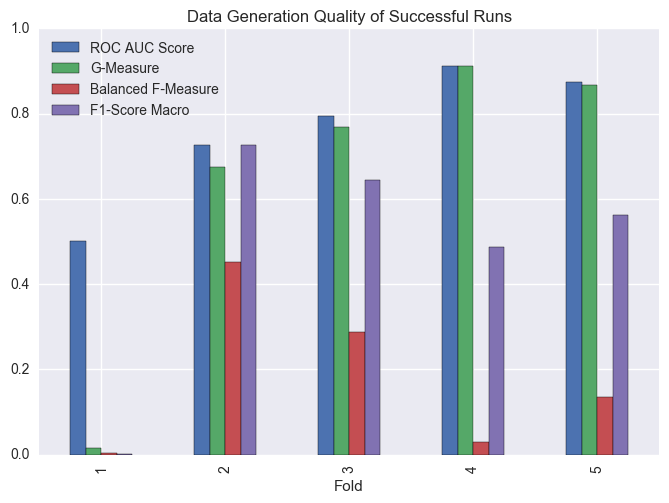

In [5]:
res = pd.read_csv('results/{0}/results_detailed.csv'.format(experiment_id))
res_filtered = res[res['Oversampling'] == 'K-Means on Autoencoder Encoding']
display(res_filtered[['Fold','ROC AUC Score','G-Measure','Balanced F-Measure','F1-Score Macro','AE Loss MSE Validation', 'Minority Cluster Count']].set_index('Fold'))
res_filtered[['Fold','ROC AUC Score','G-Measure','Balanced F-Measure','F1-Score Macro']].set_index('Fold').plot.bar(title='Data Generation Quality of Successful Runs')

In [6]:
ae_by_fold = []
weights_by_fold = []
generated_samples_by_fold = []
for fold in range(1,6):
    try: weights = np.load('results/{0}/Creditcard Fraud/{1}/ae_weights.npy'.format(experiment_id,fold))
    except: weights = np.load('results/{0}/Creditcard Fraud/{1}/{2}/ae_weights.npy'.format(experiment_id,fold,'autoencoder_kmeans'))
    ae_by_fold.append( autoencoder_keras.Autoencoder.from_weights(weights,X) )
    weights_by_fold.append(weights)
    try: generated_samples = np.load('results/{0}/Creditcard Fraud/{1}/generated_samples_k-means_on_autoencoder_encoding.npy'.format(experiment_id,fold))
    except: generated_samples = np.empty(shape=(0,30))
    generated_samples_by_fold.append(generated_samples)

In [7]:
# Encode the full original dataset to the hidden layer's two dimensions
X_encoded_by_fold = []
for i,ae in enumerate(ae_by_fold):
    X_encoded_by_fold.append( ae.encode(X) )

In [9]:
print([l.shape for l in X_encoded_by_fold])
print([l[:,0:2].shape for l in creation_examples_by_fold])

[(284807, 2), (284807, 2), (284807, 2), (284807, 2), (284807, 2)]
[(227450, 2), (227450, 2), (227450, 2), (227451, 2), (227449, 2)]


In [7]:
# Re-encode the generated samples. Although these were generated in the two dimensional space, 
# we only have the final (decoded) version available. 
# This re-encoding is an approximation of where they were really generated.
generated_samples_encoded_by_fold = []
for i,ae in enumerate(ae_by_fold):
    gen_samples_enc = np.asarray(ae.encode(generated_samples_by_fold[i]))
    if gen_samples_enc.size < 1:
        gen_samples_enc = np.empty(shape=(0,2))
    generated_samples_encoded_by_fold.append( gen_samples_enc )

In [8]:
gen_samples_enc_by_fold = []
for fold in range(1,6):
    try: gen_2d = np.load('results/{0}/Creditcard Fraud/{1}/generated_samples_encoded_k-means_on_autoencoder_encoding.npy'.format(experiment_id,fold))
    except: gen_2d = np.empty(shape=(0,2))
    gen_samples_enc_by_fold.append(gen_2d)

In [8]:
creation_examples_by_fold = []
for fold in range(1,6):
    try: 
        creation_examples = np.asarray(
            [(a,b,c,d,e,f) for (a,b),(c,d),(e,f) in 
            np.load('results/{0}/Creditcard Fraud/{1}/encoded_creation_examples_k-means_on_autoencoder_encoding.npy'.format(experiment_id,fold))]
        )
    except:
        creation_examples = np.empty(shape=(0,6))
    creation_examples_by_fold.append(creation_examples)

#### Legend

- **Black**: Encoded Majority Instances
- **Red**: Encoded Minority Instances
- **Green**: Re-encoded Generated Minority Samples
- **Blue**: Generated Minority Samples extracted from hidden layer

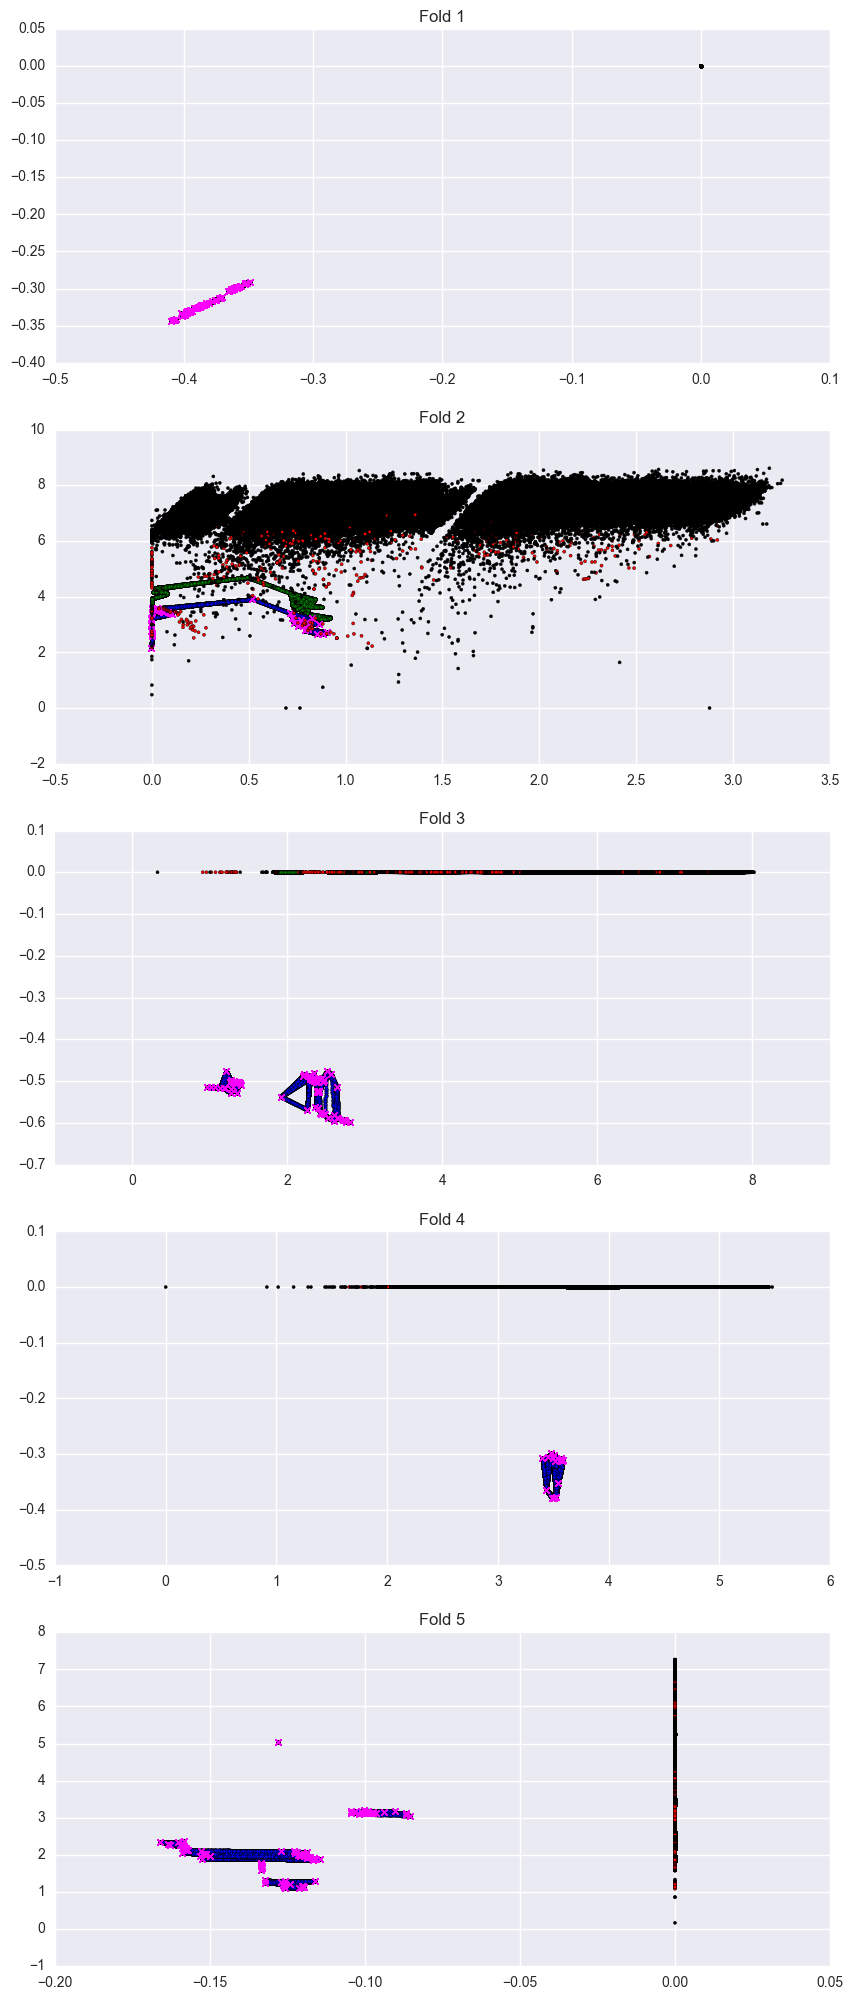

In [67]:
fig,axes = plt.subplots(nrows=len(X_encoded_by_fold), ncols=1, figsize=(10,5*len(X_encoded_by_fold)))
for i, X_encoded in enumerate(X_encoded_by_fold):
    axes[i].scatter(generated_samples_encoded_by_fold[i][:,0],generated_samples_encoded_by_fold[i][:,1], c='green', marker='.')
    axes[i].scatter(gen_samples_enc_by_fold[i][:,0],gen_samples_enc_by_fold[i][:,1], c='blue', marker='.')
    axes[i].scatter(creation_examples_by_fold[i][:,0],creation_examples_by_fold[i][:,1], c='magenta', marker='x')
    axes[i].scatter(creation_examples_by_fold[i][:,4],creation_examples_by_fold[i][:,5], c='magenta', marker='x')
    axes[i].scatter(X_encoded[:,0],X_encoded[:,1], c=np.asarray(['black','red'])[X_target], marker='.')
    axes[i].set_title('Fold {0}'.format(i+1))

In [11]:
dec_enc = lambda a: ae_by_fold[i].encode(ae_by_fold[i].decode(a))lambda  a: ae_by_fold[i].encode(ae_by_fold[i].decode(a))
fig,axes = plt.subplots(nrows=len(X_encoded_by_fold), ncols=1, figsize=(10,5*len(X_encoded_by_fold)))
for i, X_encoded in enumerate(X_encoded_by_fold):
#     axes[i].scatter(generated_samples_encoded_by_fold[i][:,0],generated_samples_encoded_by_fold[i][:,1], c='green', marker='.')
#     axes[i].scatter(gen_samples_enc_by_fold[i][:,0],gen_samples_enc_by_fold[i][:,1], c='blue', marker='.')
    x,y = 
    axes[i].scatter( c='magenta', marker='x')
    axes[i].scatter(creation_examples_by_fold[i][:,4],creation_examples_by_fold[i][:,5], c='magenta', marker='x')
    axes[i].scatter(X_encoded[(X_target==1),0],X_encoded[(X_target==1),1], c=np.asarray(['black','red'])[X_target], marker='+')
    axes[i].set_title('Fold {0}'.format(i+1))

SyntaxError: invalid syntax (<ipython-input-11-7403c83ed8f2>, line 1)

In [58]:
i = 2
fold = i+1
creation_examples = np.asarray(
    [(a,b,c,d,e,f) for (a,b),(c,d),(e,f) in 
    np.load('results/{0}/Creditcard Fraud/{1}/encoded_creation_examples_k-means_on_autoencoder_encoding.npy'.format(experiment_id,fold))]
)
creation_examples = creation_examples[:,:]

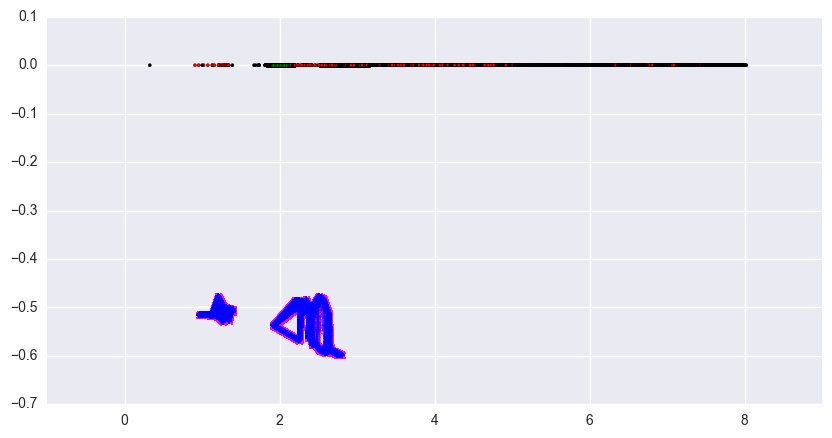

In [59]:

X_encoded = X_encoded_by_fold[i]
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
# ax.plot([creation_examples[:,0],creation_examples[:,4]],[creation_examples[:,1],creation_examples[:,5]], c='green')
    
# ax.scatter(generated_samples_encoded_by_fold[i][:,0],generated_samples_encoded_by_fold[i][:,1], c='green', marker='o')

ax.scatter(creation_examples[:,0],creation_examples[:,1], c='magenta', marker='x')
ax.scatter(creation_examples[:,2],creation_examples[:,3], c='magenta', marker='x')
ax.scatter(creation_examples[:,4],creation_examples[:,5], c='magenta', marker='x')
ax.scatter(gen_samples_enc_by_fold[i][:,0],gen_samples_enc_by_fold[i][:,1], c='blue', marker='+')
ax.scatter(generated_samples_encoded_by_fold[i][:,0],generated_samples_encoded_by_fold[i][:,1], c='green', marker='.')
# ax.scatter(creation_examples[:,0],creation_examples[:,1], c='red', marker='o')
# ax.scatter(creation_examples[:,4],creation_examples[:,5], c='red', marker='o')
ax.scatter(X_encoded[:,0],X_encoded[:,1], c=np.asarray(['black','red'])[X_target], marker='.')
# ax.set_title('Fold {0}'.format(i+1))


In [50]:
print(creation_examples)
gen_samples_enc_by_fold[i]

[[-0.11619879  1.89263189 -0.11622477  1.89457643 -0.1163974   1.90749526]
 [-0.13368793  1.77818787 -0.13353319  1.77590013 -0.13351336  1.77560675]
 [-0.1163974   1.90749526 -0.11625583  1.90525484 -0.11466781  1.88012218]
 ..., 
 [-0.12800509  5.05079699 -0.12807775  5.05025721 -0.12813428  5.04983759]
 [-0.12813428  5.04983759 -0.12803556  5.05057049 -0.12800509  5.05079699]
 [-0.12800509  5.05079699 -0.12801388  5.05073166 -0.12813428  5.04983759]]


array([[ 2.35129595, -0.49929959],
       [ 2.23072577, -0.49037072],
       [ 2.27085662, -0.48920408],
       ..., 
       [ 2.4654963 , -0.49956313],
       [ 2.48611641, -0.48768038],
       [ 2.61155462, -0.58193773]])

The following output shows weights (without biases) per layer (horizontal) and fold (vertical) just to eyeball zeros.

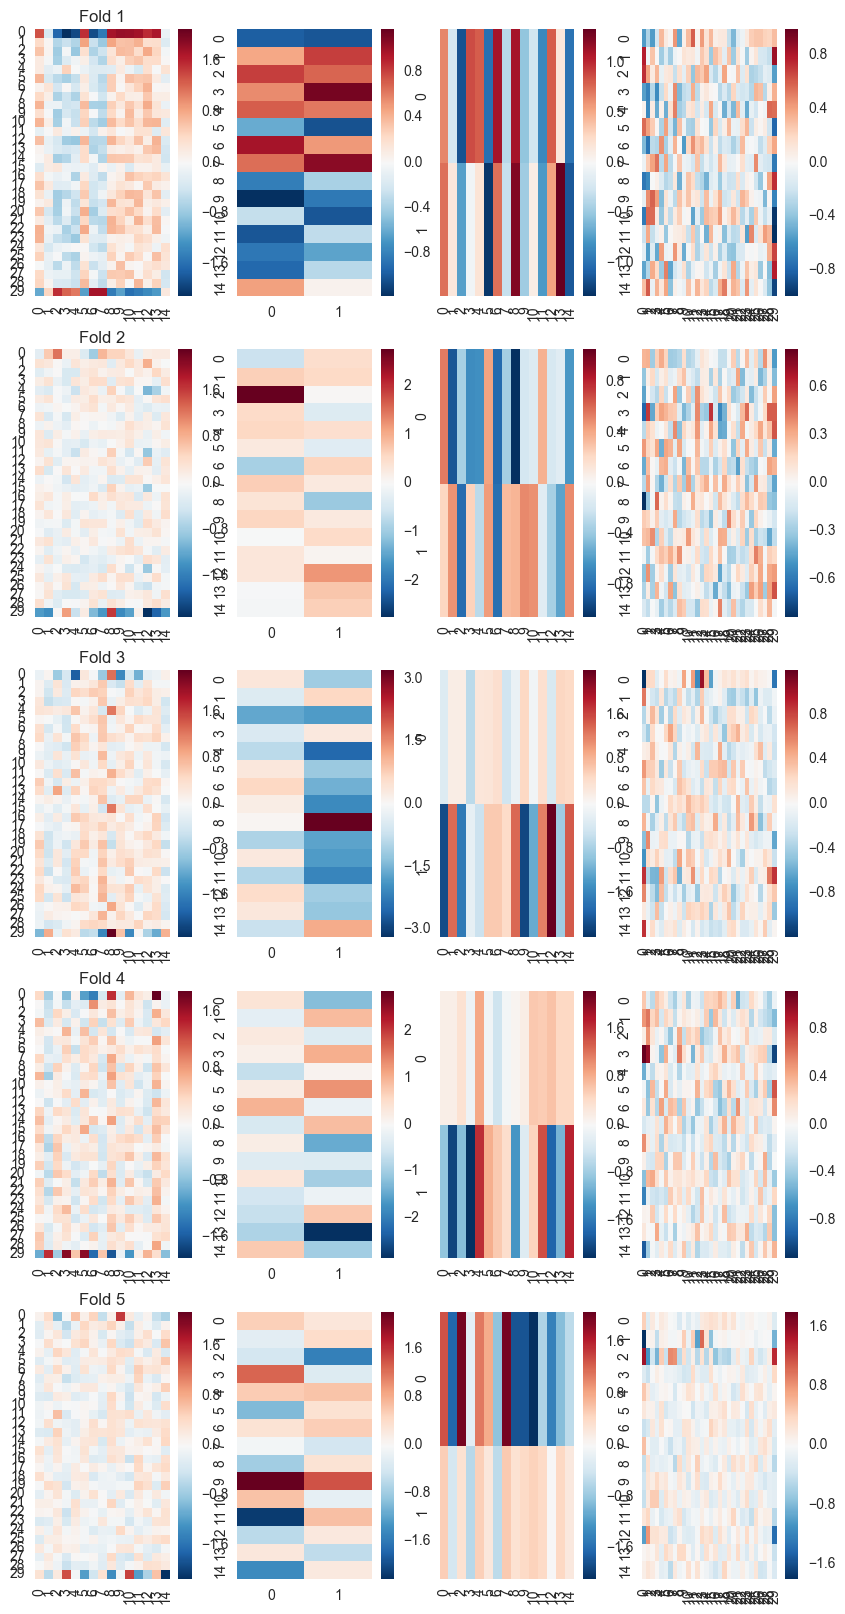

In [51]:
fig,axes = plt.subplots(nrows=len(weights_by_fold), ncols=len(weights_by_fold[0])//2, figsize=(10,5*len(weights_by_fold[0])//2))
for i, weights in enumerate(weights_by_fold):
    for j,w in enumerate(weights[::2]):
        sns.heatmap(w, ax=axes[i][j])
    axes[i][0].set_title('Fold {0}'.format(i+1))